In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/comp5331

/content/drive/.shortcut-targets-by-id/1OQ0UjZ02TMNHr3_7Y0pZWfl_ufiP_o2h/comp5331


In [3]:
from data_loader import ImbalanceDataset
from model import model, loss
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from  torch.autograd import Variable
from torchvision.utils import save_image
from model import model, loss
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
import copy

dtype = torch.FloatTensor

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68503 sha256=23bf2e9a3bc61fdb0509af67ff07e838114a47811f5ca8a9692e9f6c0b03042e
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [ ]:
trainset, testset = ImbalanceDataset.get_dataset("fminst")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=200,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=200,shuffle=True)

In [ ]:
args = {}
args['dim_h'] = 40         # factor controlling size of hidden layers
args['n_channel'] = 1      # number of channels in the input data (MNIST = 1, greyscale)
args['n_z'] = 100           # number of dimensions in latent space. 
args['n_class'] = 10           # number of classes. 
args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.00005        # learning rate for Adam optimizer
args['epochs'] = 20       # how many epochs to run for
args['batch_size'] = 200   # batch size for SGD
args['save'] = True       # save weights at each epoch of training if True
args['train'] = True      # train networks if True, else load networks from saved weights
args['dataset'] = 'fmnist' # specify which dataset to use
args['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [ ]:
scdl = model.AE(args = args)
scdl = scdl.to(args['device'])

In [ ]:
#Assume normal distribution
def sample_z(n_sample=None, dim=None, sigma=None, template=None):
  return sigma*Variable(template.data.new(template.size()).normal_())

In [ ]:
losses = []
recon_losses = []
mmd_losses = []
sv_losses = []

lambda_1, lambda_2 = torch.tensor(1), torch.tensor(1)

optim = torch.optim.Adam(scdl.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
CEL = nn.CrossEntropyLoss()
for epoch in range(args['epochs']): 
  match_sum, sv_sum, recon_sum = 0, 0, 0
  for images, labels in tqdm(train_loader):
    images = images.to(args['device'])
    labels = labels.to(args['device'])

    optim.zero_grad()
  
    x_recon, z_tilde, y_pred = scdl(images)
    z = loss.sample_z(template=z_tilde, sigma=args['sigma'])

    recon_loss = loss.mse_loss(x_recon, images ,train_loader.batch_size, size_average=False)
    mmd_loss = loss.mmd(z_tilde, z, z_var=args['sigma'])
    sv_loss = CEL(y_pred, labels)


    total_loss = recon_loss +lambda_1 *mmd_loss + lambda_2*sv_loss
    match_sum += mmd_loss.item()
    sv_sum += sv_loss.item()
    recon_sum += recon_loss.item()
    
    recon_losses.append(recon_loss.item())

    mmd_losses.append(mmd_loss.item())
    sv_losses.append(sv_loss.item())
    losses.append(total_loss.item())
    total_loss.backward()
    optim.step()
  lambda_1 = 0.5 *lambda_1 + 0.25 *(match_sum/recon_sum + match_sum/sv_sum )
  lambda_2 = 0.5 *lambda_2 + 0.25 *(sv_sum/recon_sum + sv_sum/match_sum )
  print("\n",lambda_1, lambda_2)

  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|▋         | 3/45 [00:00<00:01, 27.20it/s]


 tensor(0.5197) tensor(3.7338)


  7%|▋         | 3/45 [00:00<00:01, 26.61it/s]


 tensor(0.2908) tensor(3.9755)


  7%|▋         | 3/45 [00:00<00:01, 26.36it/s]


 tensor(0.1884) tensor(3.5118)


  7%|▋         | 3/45 [00:00<00:01, 26.38it/s]


 tensor(0.1473) tensor(2.9927)


  7%|▋         | 3/45 [00:00<00:01, 26.51it/s]


 tensor(0.1349) tensor(2.5697)


  7%|▋         | 3/45 [00:00<00:01, 27.59it/s]


 tensor(0.1351) tensor(2.2578)


  7%|▋         | 3/45 [00:00<00:01, 26.58it/s]


 tensor(0.1406) tensor(2.0324)


  7%|▋         | 3/45 [00:00<00:01, 26.45it/s]


 tensor(0.1484) tensor(1.8636)


  7%|▋         | 3/45 [00:00<00:01, 26.78it/s]


 tensor(0.1570) tensor(1.7320)


  7%|▋         | 3/45 [00:00<00:01, 21.47it/s]


 tensor(0.1650) tensor(1.6326)


  7%|▋         | 3/45 [00:00<00:01, 26.19it/s]


 tensor(0.1723) tensor(1.5559)


  7%|▋         | 3/45 [00:00<00:01, 27.28it/s]


 tensor(0.1795) tensor(1.4901)


  7%|▋         | 3/45 [00:00<00:01, 27.31it/s]


 tensor(0.1858) tensor(1.4384)


  7%|▋         | 3/45 [00:00<00:01, 27.11it/s]


 tensor(0.1918) tensor(1.3927)


  7%|▋         | 3/45 [00:00<00:01, 27.52it/s]


 tensor(0.1972) tensor(1.3546)


  7%|▋         | 3/45 [00:00<00:01, 25.47it/s]


 tensor(0.2025) tensor(1.3201)


  7%|▋         | 3/45 [00:00<00:01, 25.55it/s]


 tensor(0.2067) tensor(1.2931)


  7%|▋         | 3/45 [00:00<00:01, 26.86it/s]


 tensor(0.2109) tensor(1.2683)


  7%|▋         | 3/45 [00:00<00:01, 27.01it/s]


 tensor(0.2151) tensor(1.2444)


100%|██████████| 45/45 [00:01<00:00, 26.13it/s]


 tensor(0.2185) tensor(1.2254)


In [ ]:
def get_class_distribution(ae, target_class):
  z_c = torch.zeros(size=(1, 100))
  for i, (images, labels) in enumerate(train_loader):
    z = ae.encoder(images)
    if i == 0:
      z_c = z[labels == target_class]
    else:
      z_c = torch.cat((z_c, z[labels == target_class]), dim=0)

  return z_c.mean(dim=0), z_c.std(dim=0)

In [ ]:
def generate_data(netG, name, classes, classes_distribution, latent):
  labels = torch.full(size=(1,classes_distribution[0]), fill_value=0)
  mean_0, std_0 = get_class_distribution(latent, 0) 
  fake_0 = mean_0 + torch.normal(0.0, 1.0, size=(100, 1)).squeeze() * std_0
  images = netG(fake_0.cuda())

  with torch.no_grad():
    netG.eval()
    for i in classes:
      if(i > 0):
        mean_0, std_0 = get_class_distribution(latent, i) 
        fake_0 = mean_0 + torch.normal(0.0, 1.0, size=(100, 1)).squeeze() * std_0
        img = netG(fake_0.cuda())
        images = torch.cat((images, img),0)
        labels = torch.cat((labels, torch.full(size=(1,classes_distribution[i]), fill_value=i)),1)

      for j in tqdm(range(classes_distribution[i]-1)):
        #mean_0, std_0 = get_class_distribution(scdl, i) 
        fake_0 = mean_0 + torch.normal(0.0, 1.0, size=(100, 1)).squeeze() * std_0 # sample z of class 0
        img = netG(fake_0.cuda())
        images = torch.cat((images, img),0)
        #plt.imshow(torch.Tensor.cpu(img).view((28, 28)), cmap='gray')
        #plt.show()
    print(labels[0].shape)
    print(images.shape)
    dataset = torch.utils.data.TensorDataset(torch.Tensor.cpu(images), labels[0])
    # torch.save(dataset, 'FMNIST_balance/'+name)
    return dataset

In [ ]:
SCDLGAN_G = torch.load('fminst_SCDLGAN_G')
scdl.eval()
scdl = scdl.to('cpu')

In [ ]:
# Convert original dataset to tensor
temp_data = np.empty((0, 784))
temp_label = np.empty((0, 1))
for i in trainset:
  temp_data = np.append(temp_data, i[0])
  temp_label = np.append(temp_label, i[1])
temp_data_tensor = torch.Tensor(temp_data.reshape(9000,1,28,28))
temp_label_tensor = torch.Tensor(temp_label)
trainset_tensor = torch.utils.data.TensorDataset(temp_data_tensor, temp_label_tensor)

In [ ]:
# Load test data
test_data = np.empty((0, 784))
test_label = np.empty((0, 1))
for i in testset:
  test_data = np.append(test_data, i[0])
  test_label = np.append(test_label, i[1])
test_data = test_data.reshape(10000,1,28,28)

In [ ]:
classes_freq = {}
for _, labels in train_loader:
  for label in labels: 
    classes_freq[label.item()] = classes_freq.get(label.item(), 0) + 1

In [ ]:
classes = list(range(len(classes_freq)))
classes_distribution = list()
for i in classes:
  classes_distribution.append(4500-classes_freq[i])

In [ ]:
name = 'SCDLGAN.pt'
generated_dataset = generate_data(SCDLGAN_G, name, classes, classes_distribution, scdl)

100%|██████████| 4459/4459 [00:07<00:00, 576.31it/s]


torch.Size([36000])
torch.Size([36000, 1, 28, 28])


In [ ]:
new_dataset = torch.utils.data.ConcatDataset([trainset_tensor, generated_dataset])
new_train_loader = torch.utils.data.DataLoader(dataset=new_dataset, batch_size=200,shuffle=True)

In [ ]:
new_classes_freq = {}
for _, labels in new_train_loader:
  for label in labels: 
    new_classes_freq[label.item()] = new_classes_freq.get(label.item(), 0) + 1
new_classes_freq

{0.0: 4500,
 1.0: 4500,
 2.0: 4500,
 3.0: 4500,
 4.0: 4500,
 5.0: 4500,
 6.0: 4500,
 7.0: 4500,
 8.0: 4500,
 9.0: 4500}

In [ ]:
classes = list(range(len(classes_freq)))
classes_distribution = list()
for i in classes:
  classes_distribution.append(10000-classes_freq[i])

In [ ]:
name = 'SCDLGAN_large.pt'
generated_dataset_large = generate_data(SCDLGAN_G, name, classes, classes_distribution, scdl)

100%|██████████| 9959/9959 [00:35<00:00, 276.84it/s]


torch.Size([91000])
torch.Size([91000, 1, 28, 28])


In [ ]:
new_dataset_large = torch.utils.data.ConcatDataset([trainset_tensor, generated_dataset_large])
new_train_loader_large = torch.utils.data.DataLoader(dataset=new_dataset_large, batch_size=200,shuffle=True)

In [ ]:
classes = list(range(len(classes_freq)))
classes_distribution = list()
for i in classes:
  classes_distribution.append(6000-classes_freq[i])

In [ ]:
name = 'SCDLGAN_medium.pt'
generated_dataset_medium = generate_data(SCDLGAN_G, name, classes, classes_distribution, scdl)

100%|██████████| 5959/5959 [00:13<00:00, 441.20it/s]


torch.Size([51000])
torch.Size([51000, 1, 28, 28])


In [ ]:
new_dataset_medium = torch.utils.data.ConcatDataset([trainset_tensor, generated_dataset_medium])
new_train_loader_medium = torch.utils.data.DataLoader(dataset=new_dataset_medium, batch_size=200,shuffle=True)

In [ ]:
def train(model, loss_fn, optimizer, loader, num_epochs = 1):
    loss_hist = list()
    acc_hist = {'train': [], 'test': []}
    for epoch in range(num_epochs):
        epoch_loss = list()
        correct = 0
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            correct += (torch.Tensor.cpu(torch.argmax(scores, axis=1)) == y).float().sum().item()
        model.eval()
        test_scores = model(torch.from_numpy(test_data).to(args['device'], dtype=torch.float))
        test_acc = (torch.Tensor.cpu(torch.argmax(test_scores, axis=1)).numpy() == test_label).mean()
        print('loss: ', sum(epoch_loss)/len(epoch_loss), 'train acc: ', round(correct/len(loader.dataset), 3), 'test acc: ', round(test_acc, 3))
        loss_hist.append(sum(epoch_loss)/len(epoch_loss))
        acc_hist['train'].append(correct/len(loader.dataset))
        acc_hist['test'].append(test_acc)
    return loss_hist, acc_hist

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [ ]:
base = nn.Sequential(
                    nn.BatchNorm2d(1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(1, 64, 3, 1), #26*26*8
                     
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 32, 3, 1), #26*26*8
                     
                    nn.MaxPool2d(2, 2), #13*13*8
                     
                    nn.Flatten(),
                    nn.Linear(4608, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 128),
                    nn.ReLU(inplace=True),
                    nn.Linear(128, 10)
            )

In [ ]:
print(base)
print('# parameters', sum(p.numel() for p in base.parameters()))

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU(inplace=True)
  (2): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=4608, out_features=1024, bias=True)
  (9): ReLU(inplace=True)
  (10): Linear(in_features=1024, out_features=128, bias=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=128, out_features=10, bias=True)
)
# parameters 4871340


In [ ]:
dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

In [ ]:
model_normal = copy.deepcopy(base).type(gpu_dtype)

loss_fn_normal = nn.CrossEntropyLoss().type(dtype)
optimizer_normal = torch.optim.SGD(model_normal.parameters(), 5e-4, 0.9)

model_normal.apply(reset)
model_normal_loss, model_normal_acc = train(model_normal, loss_fn_normal, optimizer_normal, train_loader, num_epochs=30)
check_accuracy(model_normal, test_loader)

Starting epoch 1 / 30
loss:  2.0784383508894178 train acc:  0.475 test acc:  0.165
Starting epoch 2 / 30
loss:  1.481341732872857 train acc:  0.596 test acc:  0.19
Starting epoch 3 / 30
loss:  1.086960824330648 train acc:  0.673 test acc:  0.242
Starting epoch 4 / 30
loss:  0.8565125240219964 train acc:  0.709 test acc:  0.288
Starting epoch 5 / 30
loss:  0.7379915250672234 train acc:  0.747 test acc:  0.37
Starting epoch 6 / 30
loss:  0.6610990537537469 train acc:  0.787 test acc:  0.42
Starting epoch 7 / 30
loss:  0.6041761689715915 train acc:  0.81 test acc:  0.445
Starting epoch 8 / 30
loss:  0.5602277318636576 train acc:  0.821 test acc:  0.462
Starting epoch 9 / 30
loss:  0.5277874986330668 train acc:  0.828 test acc:  0.472
Starting epoch 10 / 30
loss:  0.49978606700897216 train acc:  0.838 test acc:  0.477
Starting epoch 11 / 30
loss:  0.4772413584921095 train acc:  0.841 test acc:  0.494
Starting epoch 12 / 30
loss:  0.45689286059803436 train acc:  0.848 test acc:  0.506
Start

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 7295 / 10000 correct (72.95)


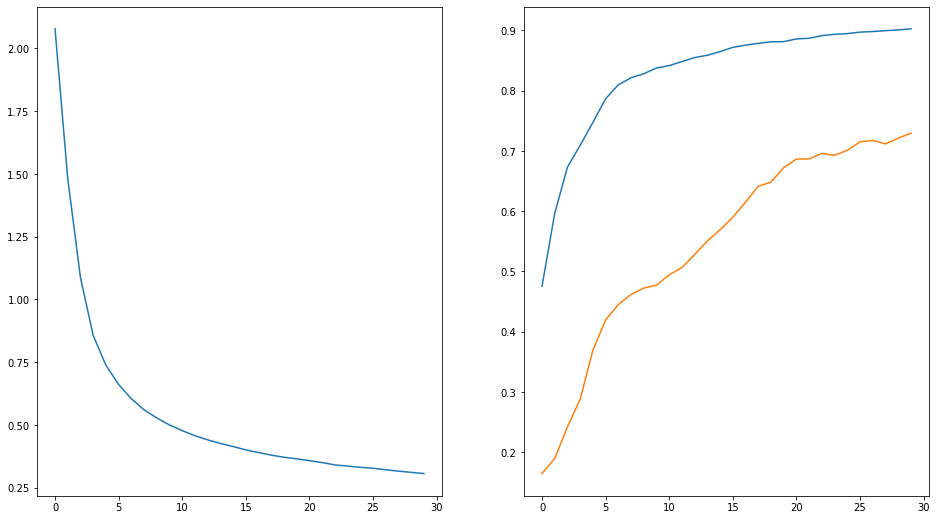

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.plot(range(len(model_normal_loss)), model_normal_loss, label = 'model_normal_loss')
for phase in ('train', 'test'):
    ax2.plot(range(len(model_normal_acc[phase])), model_normal_acc[phase], label=('model_normal_' + phase + '_acc'))

In [ ]:
model_gen = copy.deepcopy(base).type(gpu_dtype)

loss_fn_gen = nn.CrossEntropyLoss().type(dtype)
optimizer_gen = torch.optim.SGD(model_gen.parameters(), 5e-4, 0.9)

model_gen.apply(reset)
model_gen_loss, model_gen_acc = train(model_gen, loss_fn_gen, optimizer_gen, new_train_loader, num_epochs=30)
check_accuracy(model_gen, test_loader)

Starting epoch 1 / 30
loss:  2.0865394099553427 train acc:  0.277 test acc:  0.255
Starting epoch 2 / 30
loss:  1.5349607499440512 train acc:  0.509 test acc:  0.369
Starting epoch 3 / 30
loss:  1.0133695189158123 train acc:  0.647 test acc:  0.453
Starting epoch 4 / 30
loss:  0.8137604157129924 train acc:  0.697 test acc:  0.523
Starting epoch 5 / 30
loss:  0.7251658015780978 train acc:  0.719 test acc:  0.557
Starting epoch 6 / 30
loss:  0.6727271922429403 train acc:  0.735 test acc:  0.601
Starting epoch 7 / 30
loss:  0.6363984831174214 train acc:  0.748 test acc:  0.608
Starting epoch 8 / 30
loss:  0.6099777376651764 train acc:  0.756 test acc:  0.669
Starting epoch 9 / 30
loss:  0.5853788706991407 train acc:  0.767 test acc:  0.676
Starting epoch 10 / 30
loss:  0.5678161436981625 train acc:  0.773 test acc:  0.711
Starting epoch 11 / 30
loss:  0.5503755387994979 train acc:  0.781 test acc:  0.71
Starting epoch 12 / 30
loss:  0.5357425977124108 train acc:  0.787 test acc:  0.73
Sta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 7852 / 10000 correct (78.52)


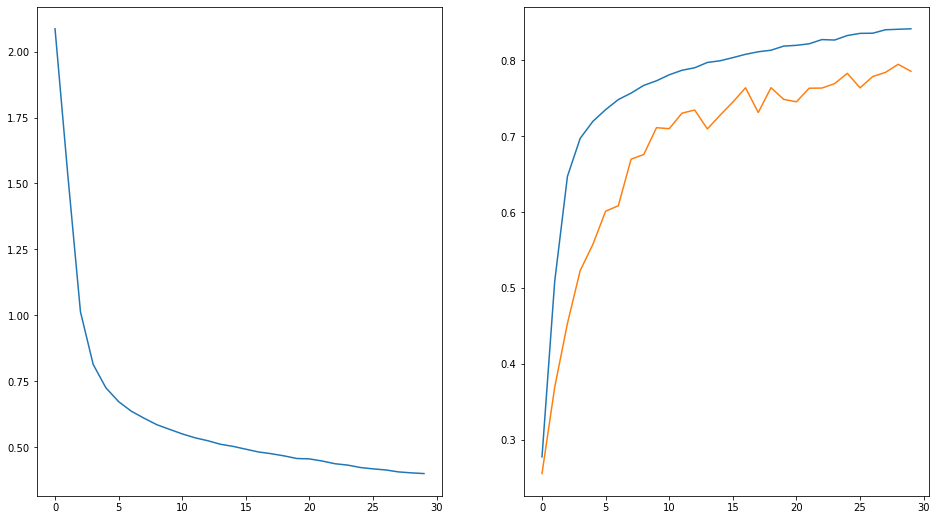

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.plot(range(len(model_gen_loss)), model_gen_loss, label = 'model_gen_loss')
for phase in ('train', 'test'):
    ax2.plot(range(len(model_gen_acc[phase])), model_gen_acc[phase], label=('model_gen_' + phase + '_acc'))

In [ ]:
model_gen_large = copy.deepcopy(base).type(gpu_dtype)

loss_fn_gen_large = nn.CrossEntropyLoss().type(dtype)
optimizer_gen_large = torch.optim.SGD(model_gen_large.parameters(), 5e-4, 0.9)

model_gen_large.apply(reset)
model_gen_large_loss, model_gen_large_acc = train(model_gen_large, loss_fn_gen_large, optimizer_gen_large, new_train_loader_large, num_epochs=40)
check_accuracy(model_gen_large, test_loader)

Starting epoch 1 / 40
loss:  1.4839667201042175 train acc:  0.55 test acc:  0.457
Starting epoch 2 / 40
loss:  0.5984093448519707 train acc:  0.786 test acc:  0.475
Starting epoch 3 / 40
loss:  0.4419150498509407 train acc:  0.837 test acc:  0.559
Starting epoch 4 / 40
loss:  0.37846955436468127 train acc:  0.859 test acc:  0.623
Starting epoch 5 / 40
loss:  0.33760726016759873 train acc:  0.872 test acc:  0.624
Starting epoch 6 / 40
loss:  0.3096178093850613 train acc:  0.884 test acc:  0.656
Starting epoch 7 / 40
loss:  0.2890037049949169 train acc:  0.891 test acc:  0.685
Starting epoch 8 / 40
loss:  0.270220661342144 train acc:  0.898 test acc:  0.683
Starting epoch 9 / 40
loss:  0.25616653391718863 train acc:  0.904 test acc:  0.66
Starting epoch 10 / 40
loss:  0.243383020401001 train acc:  0.909 test acc:  0.709
Starting epoch 11 / 40
loss:  0.2338134987205267 train acc:  0.912 test acc:  0.704
Starting epoch 12 / 40
loss:  0.2246533440053463 train acc:  0.915 test acc:  0.729
St

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 7740 / 10000 correct (77.40)


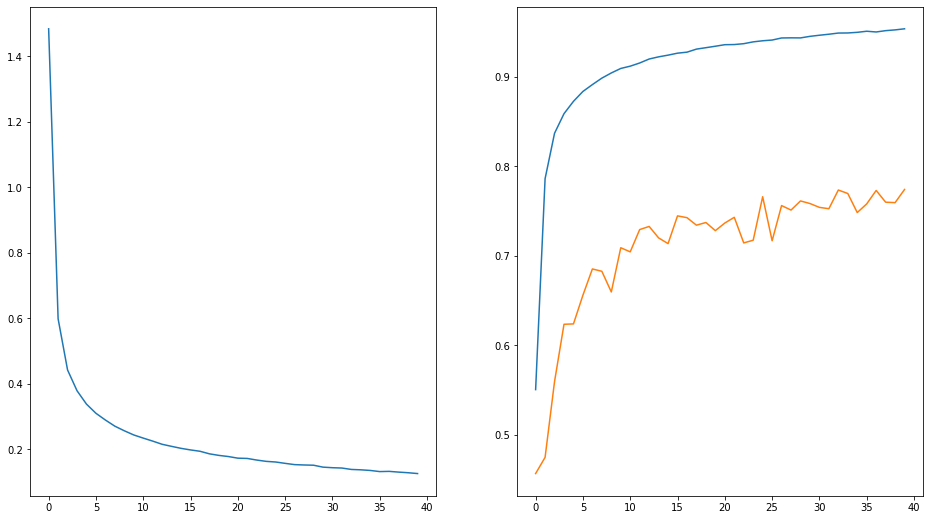

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.plot(range(len(model_gen_large_loss)), model_gen_large_loss, label = 'model_gen_loss')
for phase in ('train', 'test'):
    ax2.plot(range(len(model_gen_large_acc[phase])), model_gen_large_acc[phase], label=('model_gen_' + phase + '_acc'))

In [ ]:
model_gen_medium = copy.deepcopy(base).type(gpu_dtype)

loss_fn_gen_medium = nn.CrossEntropyLoss().type(dtype)
optimizer_gen_medium = torch.optim.SGD(model_gen_medium.parameters(), 5e-4, 0.9)

model_gen_medium.apply(reset)
model_gen_medium_loss, model_gen_medium_acc = train(model_gen_medium, loss_fn_gen_medium, optimizer_gen_medium, new_train_loader_medium, num_epochs=40)
check_accuracy(model_gen_medium, test_loader)

Starting epoch 1 / 40
loss:  1.8472854375839234 train acc:  0.369 test acc:  0.342
Starting epoch 2 / 40
loss:  0.9193049683173498 train acc:  0.718 test acc:  0.477
Starting epoch 3 / 40
loss:  0.6072430392106374 train acc:  0.782 test acc:  0.547
Starting epoch 4 / 40
loss:  0.4916671031713486 train acc:  0.82 test acc:  0.617
Starting epoch 5 / 40
loss:  0.4313676459590594 train acc:  0.84 test acc:  0.641
Starting epoch 6 / 40
loss:  0.39241797506809234 train acc:  0.853 test acc:  0.664
Starting epoch 7 / 40
loss:  0.36308799336353936 train acc:  0.864 test acc:  0.725
Starting epoch 8 / 40
loss:  0.33970951050519943 train acc:  0.873 test acc:  0.677
Starting epoch 9 / 40
loss:  0.3229254152874152 train acc:  0.879 test acc:  0.708
Starting epoch 10 / 40
loss:  0.306238290766875 train acc:  0.886 test acc:  0.728
Starting epoch 11 / 40
loss:  0.2976591577132543 train acc:  0.889 test acc:  0.728
Starting epoch 12 / 40
loss:  0.2818985882898172 train acc:  0.895 test acc:  0.738
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 7845 / 10000 correct (78.45)


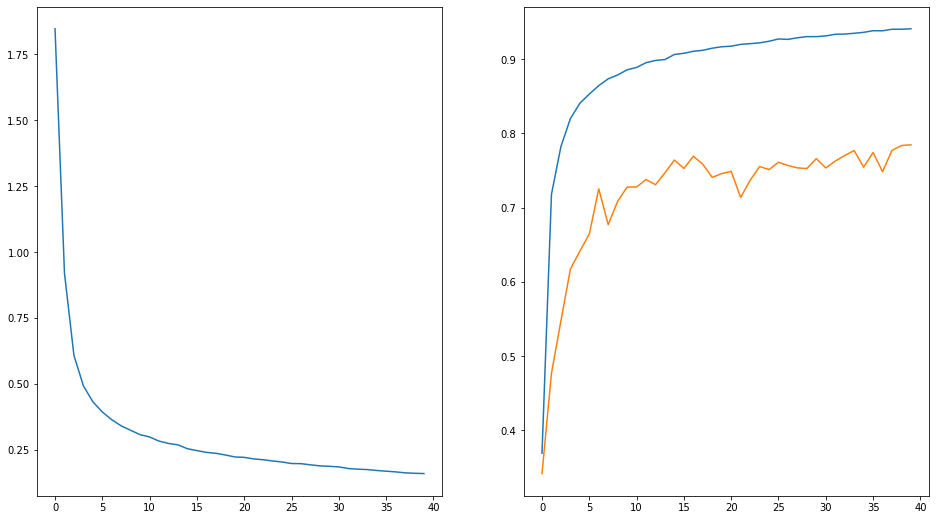

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.plot(range(len(model_gen_medium_loss)), model_gen_medium_loss, label = 'model_gen_loss')
for phase in ('train', 'test'):
    ax2.plot(range(len(model_gen_medium_acc[phase])), model_gen_medium_acc[phase], label=('model_gen_' + phase + '_acc'))

In [ ]:
torch.save(model_normal, '/use_case_model')